🔄 Carregando dataset completo...
📋 Removendo linhas com valores ausentes em colunas essenciais...
🔢 Convertendo 'tipoVoto' para binário...
🧮 Definindo features e alvo...
🎯 Amostrando 20% dos dados, mantendo proporcionalidade de classes...
🔎 Tamanho da amostra: 176190 registros
⚙️ Configurando pipeline de pré-processamento...
🚀 Iniciando validação cruzada (5 folds) em RandomForest...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=  25.2s
[CV] END .................................................... total time=  25.3s
[CV] END .................................................... total time=  25.4s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.6s remaining:   38.4s


[CV] END .................................................... total time=  25.5s
[CV] END .................................................... total time=  23.6s

📊 Resultados F1-macro por fold:
  Fold 1: 0.7430
  Fold 2: 0.7423
  Fold 3: 0.7410
  Fold 4: 0.7429
  Fold 5: 0.7444
  Média: 0.7427  |  Desvio: 0.0011

🔍 Treinando modelo em treino/teste e gerando matriz de confusão...


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s finished



✅ Relatório de Classificação (amostra 20%):
              precision    recall  f1-score   support

           0       0.81      0.84      0.82     22690
           1       0.69      0.65      0.67     12548

    accuracy                           0.77     35238
   macro avg       0.75      0.74      0.75     35238
weighted avg       0.77      0.77      0.77     35238


🔲 Matriz de Confusão:


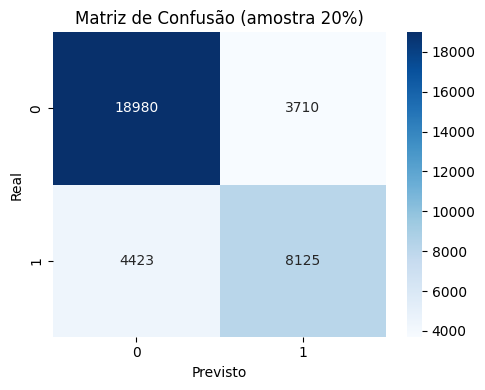

📈 Gerando boxplot final dos F1‐macro nas 5 folds (amostra 20%)...


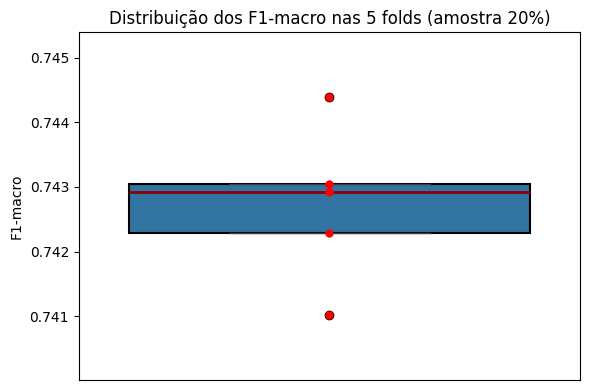

🎯 Validação cruzada e análise de erros concluídas.


In [24]:
# -*- coding: utf-8 -*-
"""
Notebook: validação_cruzada_amostra.py

Objetivo: Amostrar 20% do dataset consolidado e executar validação cruzada
          em RandomForest, para estimar tempo de execução em um Mac.
"""

# ----------------------------
# 1. Importar bibliotecas
# ----------------------------
import pandas as pd
import numpy as np
import ast
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# 2. Configurar caminhos
# ----------------------------
# Ajuste conforme a estrutura de diretórios no mac
# 2. Configurar caminhos
BASE_DIR = os.getcwd()
csv_path = os.path.join(BASE_DIR, "dados", "df_consolidado.csv")
df_full = pd.read_csv(csv_path, low_memory=False)
#RAW_CSV_PATH = "../dados/df_consolidado.csv"  # caminho para o CSV consolidado

# ----------------------------
# 3. Carregar e limpar dados
# ----------------------------
print("🔄 Carregando dataset completo...")
#df_full = pd.read_csv(RAW_CSV_PATH, low_memory=False)

print("📋 Removendo linhas com valores ausentes em colunas essenciais...")
colunas_para_remover_nan = [
    "id_votacao", "id_deputado", "tipoVoto", "siglaUf", "id_partido",
    "id_proposicao", "data", "sigla_orgao", "aprovacao", "cod_tipo",
    "numero_proposicao", "ano", "orientacao", "id_autor", "tema"
]
df_full = df_full.dropna(subset=colunas_para_remover_nan)

# Converter tipoVoto para binário (1 = Sim, 0 = Não)
print("🔢 Convertendo 'tipoVoto' para binário...")
df_full["tipoVoto"] = df_full["tipoVoto"].map({"Sim": 1, "Não": 0}).fillna(0)

# ----------------------------
# 4. Definir X_full e y_full
# ----------------------------
print("🧮 Definindo features e alvo...")
y_full = df_full["aprovacao"].astype(int)

# Selecionar colunas brutas
features = ["siglaUf", "id_partido", "cod_tipo", "numero_proposicao", "ano", "tema"]
X_full = df_full[features].copy()

# Extrair tema_principal
def extrair_tema_principal(x):
    try:
        lst = ast.literal_eval(x) if pd.notnull(x) else []
        return lst[0] if len(lst) > 0 else "Outros"
    except:
        return "Outros"

X_full["tema_principal"] = X_full["tema"].apply(extrair_tema_principal)

# Manter colunas finais e converter id_partido para int
X_full = X_full[["siglaUf", "id_partido", "cod_tipo", "ano", "tema_principal"]]
X_full["id_partido"] = X_full["id_partido"].astype(int)

# ----------------------------
# 5. Amostrar 20% dos dados (estratificado)
# ----------------------------
print("🎯 Amostrando 20% dos dados, mantendo proporcionalidade de classes...")
X_sub, _, y_sub, _ = train_test_split(
    X_full, y_full, test_size=0.80, stratify=y_full, random_state=42
)

print(f"🔎 Tamanho da amostra: {len(X_sub)} registros")

# ----------------------------
# 6. Pré-processamento dos features
# ----------------------------
print("⚙️ Configurando pipeline de pré-processamento...")

categorical_features = ["siglaUf", "tema_principal"]
numeric_features = ["id_partido", "cod_tipo", "ano"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# ----------------------------
# 7. Validção cruzada com RandomForest
# ----------------------------
print("🚀 Iniciando validação cruzada (5 folds) em RandomForest...")

model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=200,      # em vez de 100
    max_depth=20,          # limitar profundidade
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced"
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", model),
    ]
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcula F1-macro em cada fold
scores = cross_val_score(
    pipeline, X_sub, y_sub, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=2
)

print("\n📊 Resultados F1-macro por fold:")
for i, score in enumerate(scores, start=1):
    print(f"  Fold {i}: {score:.4f}")
print(f"  Média: {scores.mean():.4f}  |  Desvio: {scores.std():.4f}")

# … resto do código, até o bloco da matriz de confusão …

# 8. Treino/Validação e Matriz de Confusão
print("\n🔍 Treinando modelo em treino/teste e gerando matriz de confusão...")
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub, stratify=y_sub, test_size=0.20, random_state=42
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("\n✅ Relatório de Classificação (amostra 20%):")
print(classification_report(y_test, y_pred))

print("\n🔲 Matriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))             # nova figura para a matriz
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão (amostra 20%)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()                             # exibe a matriz antes de prosseguir

# 9. BOXPLOT DE F1‐MACRO
# 9. BOXPLOT DE F1‐MACRO COM STRIPPLOT E LIMITES AJUSTADOS
print("📈 Gerando boxplot final dos F1‐macro nas 5 folds (amostra 20%)...")

plt.figure(figsize=(6, 4))

# Desenha a caixa (boxplot)
sns.boxplot(
    data=[scores],
    whis=1.5,
    boxprops={'linewidth': 1.5, 'edgecolor': 'black'},
    whiskerprops={'linewidth': 1.5, 'color': 'black'},
    medianprops={'linewidth': 2, 'color': 'darkred'},
    flierprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'black'}
)

# Sobrepõe cada valor individual (fold) em vermelho
sns.stripplot(
    data=[scores],
    color='red',
    size=6,
    jitter=False  # sem “jitter”, para ficar exatamente alinhado verticalmente
)

plt.title("Distribuição dos F1‐macro nas 5 folds (amostra 20%)")
plt.ylabel("F1‐macro")
plt.xticks([])  # remove etiquetas no eixo X

# Ajusta limites verticalmente para que os bigodes fiquem visíveis
ymin = scores.min() - 0.001
ymax = scores.max() + 0.001
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.show()  # exibe o boxplot aprimorado

print("🎯 Validação cruzada e análise de erros concluídas.")